In [22]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import scipy as scp
from copy import copy

In [23]:
raw_seq_data = pd.read_csv('./output_seq_met_extended.csv',index_col=0)


In [24]:
des_stability_data = pd.read_csv('../ProteaseAnalysisExp2/final_features_and_stab_sc.csv',index_col=0)
des_names = [i for i in des_stability_data.index]
stable_desnames = des_stability_data.index[des_stability_data['stability_sc']>=1.55].tolist()
unstable_desnames = des_stability_data.index[des_stability_data['stability_sc']<1.55].tolist()
#dimeric_desnames = des_stability_data.index[des_stability_data['Subunits']==2.0].tolist()
#m_stable_desnames = [ i for i in stable_desnames if i not in dimeric_desnames ]
#m_unstable_desnames = [ i for i in unstable_desnames if i not in dimeric_desnames ]
#m_desnames = [ i for i in des_names if i not in dimeric_desnames ]
#d_stable_desnames = [ i for i in stable_desnames if i in dimeric_desnames ]
#d_unstable_desnames = [ i for i in unstable_desnames if i in dimeric_desnames ]
#d_desnames = [ i for i in des_names if i in dimeric_desnames ]
stable_mon_raw_seq_data = raw_seq_data.loc[stable_desnames]
unstable_mon_raw_seq_data = raw_seq_data.loc[unstable_desnames]
mon_raw_seq_data = raw_seq_data.loc[des_names]
bg_sc_m =  float(len(stable_desnames))/float(len(des_names))
print('Background success rate: %0.4f'%bg_sc_m)

Background success rate: 0.2889


/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [25]:
mon_suc_rate = float(len(stable_desnames))/float(len(des_names))
def get_aa_enrich_mon(pos,aa):
    # stable stuff:
    n_success = [i for i in stable_mon_raw_seq_data[str(pos)].values].count(aa)
    n_unsuccess = [i for i in unstable_mon_raw_seq_data[str(pos)].values].count(aa)
    p_val = scp.stats.binom_test([n_success,n_unsuccess],mon_suc_rate)
    no_x_s = [i for i in stable_mon_raw_seq_data[str(pos)]].count('X')
    no_x = [i for i in mon_raw_seq_data[str(pos)]].count('X')
    stable_prop = float([i for i in stable_mon_raw_seq_data[str(pos)].values].count(aa))/(len(stable_mon_raw_seq_data[str(pos)].values)-no_x_s)
    prop = float([i for i in mon_raw_seq_data[str(pos)].values].count(aa))/(len(mon_raw_seq_data[str(pos)].values)-no_x)
    '''if (prop == 0.0):
        return 1
    else: return 0'''
    if (prop == 0.0):
        return 99.0
    if p_val > 0.05:
        return 0.0
    if(stable_prop == 0.0) :
        return -99.0
    else:
        return np.log10(stable_prop/prop)
#aas = ['A','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
aas = ['S','T','D','E','N','Q','H','K','R','G','P','F','Y','W','M','L','I','V','A']

processed_dict = { pos:{ aa:get_aa_enrich_mon(pos,aa) for aa in aas } for pos in range(65) }
final_df = pd.DataFrame.from_dict(processed_dict)

final_df.index = pd.CategoricalIndex(final_df.index, categories= aas )
final_df.sort_index(level=0, inplace=True)

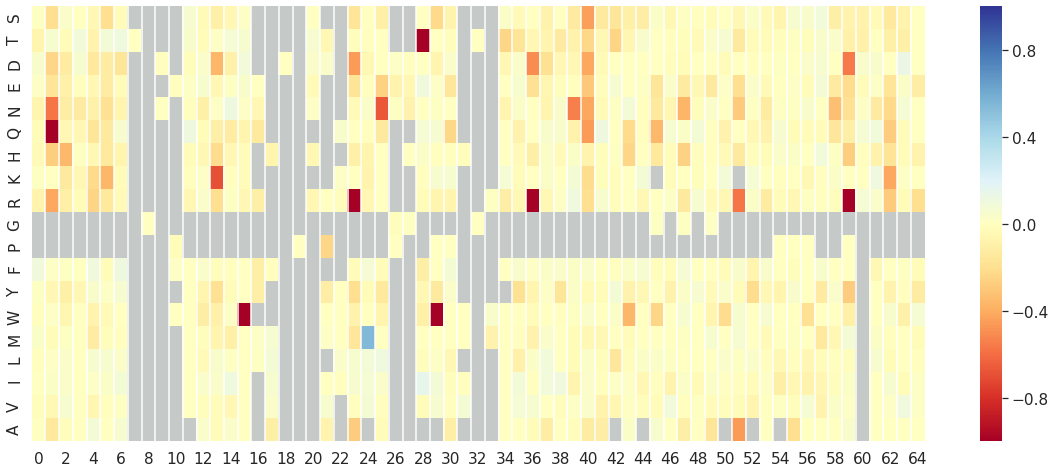

In [26]:
fig, ax = plt.subplots(figsize=(20,8))
cmap = copy(plt.cm.RdYlBu)
#cmap = copy(plt.cm.seismic)
cmap.set_over('xkcd:silver',1.0)
#cmap.set_under('xkcd:darkblue',1.0)
sns.heatmap(final_df,vmin=-1.0,vmax=1.0,ax=ax,cmap=cmap)
ax.set_ylim(19, 0)
ax.vlines([i for i in range(1,65)], *ax.get_ylim(),colors='w')
#
plt.savefig('./monomers_seq_features_extended.png', transparent=True)

In [27]:
mon_suc_rate = float(len(stable_desnames))/float(len(des_names))
def get_aa_enrich_mon(pos,cat):
    category_dict = {\
    'Hydrophobic':['F','Y','W','M','L','I','V','A'],\
    'Hydrophilic':['S','T','D','E','N','Q','H','K','R'],\
    'Glycine':['G'],\
    'Proline':['P'],\
    }
    n_success = sum( [ [i for i in stable_mon_raw_seq_data[str(pos)].values].count(aa) for aa in category_dict[cat]])
    n_unsuccess = sum( [[i for i in unstable_mon_raw_seq_data[str(pos)].values].count(aa) for aa in category_dict[cat]])
    p_val = scp.stats.binom_test([n_success,n_unsuccess],mon_suc_rate)
    no_x_s = [i for i in stable_mon_raw_seq_data[str(pos)]].count('X')
    no_x = [i for i in mon_raw_seq_data[str(pos)]].count('X')
    stable_prop = float( sum( [ [i for i in stable_mon_raw_seq_data[str(pos)].values].count(aa) for aa in category_dict[cat]] ))/(len(stable_mon_raw_seq_data[str(pos)].values)-no_x_s)
    prop = float(sum( [ [i for i in mon_raw_seq_data[str(pos)].values].count(aa)for aa in category_dict[cat]] ))/(len(mon_raw_seq_data[str(pos)].values)-no_x)
    '''if (prop == 0.0):
        return 1
    else: return 0'''
    if (prop == 0.0):
        return 99.0
    if p_val > 0.05:
        return 0.0
    if(stable_prop == 0.0) :
        return -99.0
    else:
        return np.log10(stable_prop/prop)
#aas = ['A','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
aas = ['S','T','D','E','N','Q','H','K','R','G','P','F','Y','W','M','L','I','V','A']
categories = ['Hydrophobic','Hydrophilic','Glycine','Proline']
processed_dict = { pos:{ cat:get_aa_enrich_mon(pos,cat) for cat in categories } for pos in range(65) }
final_df = pd.DataFrame.from_dict(processed_dict)

final_df.index = pd.CategoricalIndex(final_df.index, categories= categories )
final_df.sort_index(level=0, inplace=True)

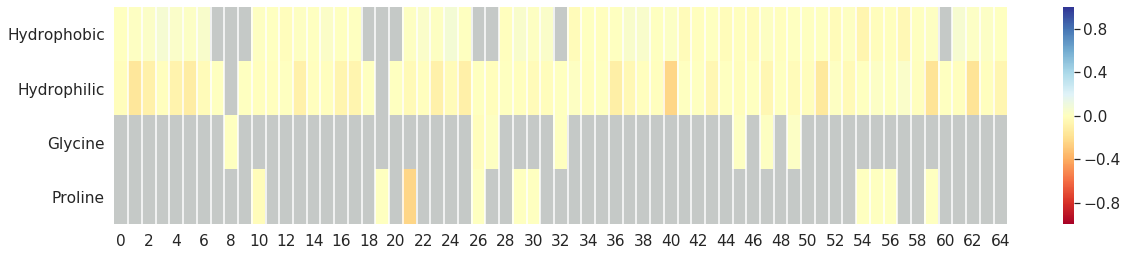

In [28]:
fig, ax = plt.subplots(figsize=(20,4))
cmap = copy(plt.cm.RdYlBu)
cmap.set_over('xkcd:silver',1.0)
#cmap.set_under('xkcd:darkblue',1.0)

sns.heatmap(final_df,vmin=-1.0,vmax=1.0,ax=ax,cmap=cmap)
sns.set(font_scale=1.4)
ax.set_ylim(4, 0)
ax.vlines([i for i in range(1,65)], *ax.get_ylim(),colors='w')
#
plt.savefig('./monomers_seq_features_extended_Rd1chip_RdYlBu.png', transparent=True)
plt.show()